In [1]:
"""
Atividade PEL219 - Multi Layer Perceptron [teste manual] - Gabriel Melo. Matrícula: 125.304-6

Versão Jupyter, para rodar será necessário apenas adicionar os datasets no diretório de execução.
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.neural_network import MLPClassifier  # just for comparison

from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder

In [2]:
from sklearn import datasets

iris = datasets.load_iris()

scaler = MinMaxScaler((-1,1))

X = scaler.fit_transform(iris['data'])
Y = OneHotEncoder(handle_unknown='ignore', sparse_output=False).fit_transform(iris['target'].reshape(-1, 1)) # mudo de (x,) para (X, 1)

x_train, x_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.3, random_state=42)  # um dos melhores resultados foi com o random state igual a 5

x_train.shape, y_train.shape, x_test.shape, y_test.shape

((105, 4), (105, 3), (45, 4), (45, 3))

# modelo do scikit learn para comparação

In [3]:
mlp = MLPClassifier(activation='logistic', solver='sgd', hidden_layer_sizes=(4), max_iter=10000)

mlp.fit(x_train, y_train)

results = mlp.predict(x_test)

In [4]:
print(classification_report(results, y_test))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        19
           1       0.00      0.00      0.00         0
           2       1.00      0.93      0.96        14

   micro avg       0.71      0.97      0.82        33
   macro avg       0.67      0.64      0.65        33
weighted avg       1.00      0.97      0.98        33
 samples avg       0.71      0.71      0.71        33



/home/melo/coding/machine-learning/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/melo/coding/machine-learning/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


## rede manual, implmentação arcaica do backpropagation

In [5]:
    
def sigmoid(x: np.array) -> np.array:
    """
    sigmoid
    """
    return 1/(1+np.exp(-x))

def d_sigmoid(x: np.array) -> np.array:
    """
    sigmoid derivative
    """
    return sigmoid(x)*(1 - sigmoid(x))

In [6]:
# rede 4, 4, 3

input_size = 4
hidden_size = 4
output_size = 3

target = y_test
input_layer =  np.concatenate((np.ones((x_test.shape[0], 1)), x_test), axis=1)  # add 1 for bias
hidden_layer = np.random.uniform(size=(input_size + 1, hidden_size))
out_layer = np.random.uniform(size=(hidden_size+1, output_size))

learning_rate = 0.1

target.shape, input_layer.shape

((45, 3), (45, 5))

In [7]:
neth1 = np.dot(input_layer, hidden_layer)
activationh1 = sigmoid(neth1)
neth1.shape, hidden_layer.shape

((45, 4), (5, 4))

In [8]:
out_input = np.concatenate((np.ones((activationh1.shape[0], 1)), activationh1), axis=1)

netol = np.dot(out_input, out_layer)
activationol = np.tanh(netol)
predict = np.heaviside(activationol - 0.5, 0.5)

netol.shape, activationol.shape, predict.shape

((45, 3), (45, 3), (45, 3))

## fitting do modelo via backpropagation

In [9]:
# calculo do erro
e_out = (target - activationol) * d_sigmoid(activationol)  # target - ativacao * derivada da rede da camada atual
e_hidden = np.dot(e_out, out_layer.T) * d_sigmoid(out_input)  # (em wk) * f'(netm) , netm + 1 do bias

e_out.shape, e_hidden.shape

((45, 3), (45, 5))

In [10]:
# calculo do delta
delta_out = learning_rate * e_out.T.dot(out_input)
delta_hidden = learning_rate * input_layer.T.dot(e_hidden)

delta_out.shape, delta_hidden[:, 1:].shape, hidden_layer.shape

((3, 5), (5, 4), (5, 4))

In [11]:
out_layer += delta_out.T

hidden_layer += delta_hidden[:, 1:]

np.mean(np.square(target - activationol))



np.float64(0.464125437964596)

# Basic implementation, changed the matrix multiplication sections, using the broadcasting function from numpy

In [12]:
# BASIC MLP CLASSIFIER, only accepts 3 layers

class MLPBasicClassifier:
    def __init__(self):
        self.loss = []
    
    def add_bias(self, X: np.array) -> np.array:
        return np.concatenate((np.ones((X.shape[0], 1)), X), axis=1)
    
    def fit(self, X: np.array, Y: np.array, epoches=15000, lr=0.01, tol=1e-2):
        # rede 4, 4, 3
        input_size = 4
        hidden_size = 4
        output_size = 3

        self.input_layer = self.add_bias(X)  # add 1 for bias
        self.hidden_layer = np.random.uniform(size=(input_size + 1, hidden_size))
        self.out_layer = np.random.uniform(size=(hidden_size+1, output_size))

        for i in range(epoches):
            # FORWARD
            neth1 = np.dot(self.input_layer, self.hidden_layer)
            activationh1 = sigmoid(neth1)

            out_input = self.add_bias(activationh1)

            netol = np.dot(out_input, self.out_layer)
            activationol = np.tanh(netol)

            # BACKPROPAGATION
            e_out = (Y - activationol) * d_sigmoid(activationol)  # target - ativacao * derivada da rede da camada atual
            e_hidden = np.dot(e_out, self.out_layer.T) * d_sigmoid(out_input)  # (em wk) * f'(netm) , netm + 1 do bias

            delta_out = lr * e_out.T.dot(out_input)
            delta_hidden = lr * self.input_layer.T.dot(e_hidden)

            self.out_layer += delta_out.T
            self.hidden_layer += delta_hidden[:, 1:]

            self.loss.append(np.mean(np.square(Y - activationol)))

            if self.loss[-1] < tol:
                break
    
    def predict(self, X: np.array):
        # FORWARD
        self.input_layer = self.add_bias(X)  # add 1 for bias

        neth1 = np.dot(self.input_layer, self.hidden_layer)
        activationh1 = sigmoid(neth1)

        out_input = self.add_bias(activationh1) # add bias for output layer

        netol = np.dot(out_input, self.out_layer)
        activationol = np.tanh(netol)

        return np.heaviside(activationol - .5, 0.5)


In [13]:
model = MLPBasicClassifier()
model.fit(x_train, y_train)

In [14]:
results = model.predict(x_test)

label_results = np.argmax(results, axis=1)
label_target = np.argmax(y_test, axis=1)

In [15]:
print(classification_report(label_results, label_target))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        19
           1       1.00      0.87      0.93        15
           2       0.85      1.00      0.92        11

    accuracy                           0.96        45
   macro avg       0.95      0.96      0.95        45
weighted avg       0.96      0.96      0.96        45



([<matplotlib.lines.Line2D at 0x75b15d54e5d0>],
 np.float64(0.035220491239275495))

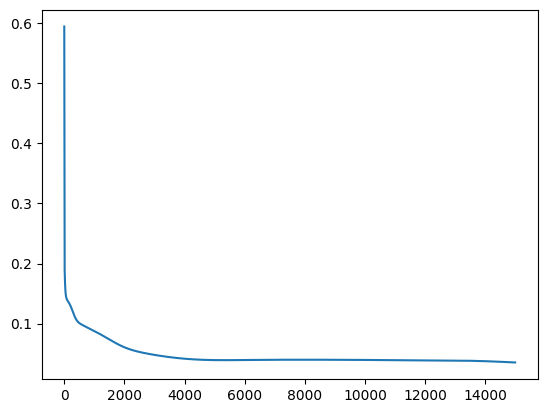

In [16]:
plt.plot(model.loss), model.loss[-1]